In [1]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras.regularizers import l2
import cv2
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt

Using TensorFlow backend.


# Architecture 1

In [2]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def get_siamese_model(input_shape, similarity_metric='l1'):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (6,6), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (6,6), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (2,2), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, kernel_regularizer=l2(1e-3),))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    if similarity_metric == 'l1':
        Similarity_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))        
    elif siamese_metric == 'l2':
        Similarity_layer = Lambda(lambda tensors:K.sqrt(K.square(tensors[0] - tensors[1])))
    elif siamese_metric == 'cross': ## TODO
        Similarity_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))     
        
    Similarity_distance = Similarity_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(Similarity_distance)
    
    # Connect the input with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    model.summary()
    return siamese_net

In [9]:
model = get_siamese_model((64, 64, 3))
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 59, 59, 64)        6976      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       295040    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 128)         262272    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 256)         131328    
__________

# Dataset

In [79]:
dataset_path = 'dataset/foods/food41/food_c101_n10099_r64x64x3.h5'
f = h5py.File(dataset_path, 'r')
test_dataset_path = 'dataset/foods/food41/food_test_c101_n1000_r64x64x3.h5'
test_f = h5py.File(dataset_path, 'r')

In [119]:
class Siamese_Loader:
    def __init__(self, i_images, 
                 train_path, test_path=None,
                 dataset_type = 'foods'):
        self.images = []
        self.labels = []
        self.category_names = []
        self.train_path = train_path
        self.test_path = test_path
        self.n_images = i_images
        self.dataset_type = dataset_type
        
        f = h5py.File(self.train_path, 'r')
        category_group_key = list(f.keys())[0]
        categoryNames_group_key = list(f.keys())[1]
        images_group_key = list(f.keys())[2]
        
        self.labels = list(f[category_group_key][i_images:])
        self.category_names = list(f[categoryNames_group_key])
        self.images = list(f[images_group_key][i_images:])
    
    def _initialize_dict(self):
        dictionary = {}
        classes = self.category_names
        for i in range(0,len(classes)):
            dictionary.update({classes[i]:0})
        return dictionary

    def check_estratos(self):
        n_class = self._initialize_dict()
        labels = self.labels
        classes = self.category_names
        for i in range(0,len(labels)):
            for tf in range(len(labels[i])):
                if labels[i][tf]:
                    n_class.update({classes[tf]:n_class[classes[tf]]+1})
        return n_class
    
    def _get_categ_number(self, indice):
        return [lb for lb in range(0,len(self.labels[indice])) if self.labels[indice][lb] == True][0]

    def get_batch(self, batch_size = 20):
        
        img_shape = self.images[0].shape
        pairs = [np.zeros((batch_size, img_shape[0], img_shape[1], img_shape[2])) for i in range(2)]
        targets = []
        
        for i in range(0,batch_size):
            idx_1 = np.random.randint(low=0, high=len(self.images), size=1)[0]
            img1 = self.images[idx_1]
            categ_img1 = self._get_categ_number(idx_1)
            target = 0
            if i < np.trunc(batch_size/2):
                while True:
                    idx_2 = np.random.randint(low=0, high=len(self.images), size=1)[0]
                    categ_2 = self._get_categ_number(idx_2)
                    if categ_2 == categ_img1:
                        img2 = self.images[idx_2]
                        categ_img2 = categ_2
                        target = 0
                        break
            else:
                while True:
                    idx_2 = np.random.randint(low=0, high=len(self.images), size=1)[0]
                    categ_2 = self._get_categ_number(idx_2)
                    if categ_2 != categ_img1:
                        img2 = self.images[idx_2]
                        categ_img2 = categ_2
                        target = 1
                        break
            pairs[0][i] = img1
            pairs[1][i] = img2
            targets.append(target)
        return pairs, targets

In [105]:
train_datapath='dataset/foods/food41/food_c101_n10099_r64x64x3.h5'
loader = Siamese_Loader(train_path=train_datapath,
                        i_images=8999)

In [107]:
pairs, targets = loader.get_batch()

In [67]:
#loader.check_estratos()

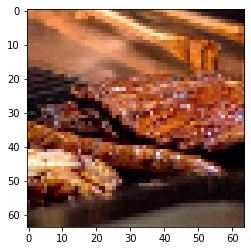

In [118]:
w = pairs[1][16].astype(int)

pt.imshow(w)

pt.show()

In [ ]:
n_class = check_estratos(data_category, data_categoryNames)

In [32]:
pairs = [np.zeros((2, 64, 64,3)) for i in range(2)]
#pairs#[0]#[0,:,:,:]

In [56]:
pairs[0][0] = loader.images[0]

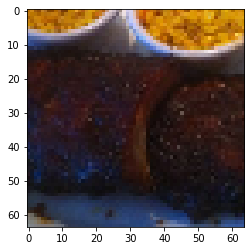

In [61]:
w = pairs[0][0].astype(int)

pt.imshow(w)

pt.show()

In [66]:
loader.images[0].shape

(64, 64, 3)

In [77]:
loader.images[0]
loader.labels[19]
i = [lb for lb in range(0,len(loader.labels[19])) if loader.labels[19][lb] == True][0]

In [78]:
i

18

In [74]:
loader.labels[19]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])